In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [2]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# 1. Setup and Data Preparation
# Load dataset
df = pd.read_csv('/content/sample_data/twitter_training.csv', names=['id', 'entity', 'sentiment', 'content'])

In [4]:
# Filter relevant sentiments (Positive, Negative, Neutral)
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]

# Handle missing values
df['content'] = df['content'].fillna('')

# Initialize NLTK tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<ipython-input-4-224c60d50f49>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].fillna('')


In [7]:
import nltk
nltk.download('punkt_tab')

# Clean and preprocess text data
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower().strip()

    # Tokenize and remove stopwords, lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['content'] = df['content'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
# Encode sentiment labels
sentiment_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
df['sentiment'] = df['sentiment'].map(sentiment_map)

In [9]:
# Tokenization and padding
max_words = 10000  # Increased vocabulary size
max_len = 150      # Increased sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [10]:
# Prepare labels
labels = tf.keras.utils.to_categorical(df['sentiment'], num_classes=3)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42, stratify=df['sentiment']
)

In [12]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df['sentiment']), y=df['sentiment'])
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.9871351766513057), 1: np.float64(0.9122526838789815), 2: np.float64(1.1226116388251992)}


In [15]:
# Download and extract GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove.6B/

# Load GloVe embeddings - Update the file path
embedding_dim = 100
embedding_index = {}
# Update the path to the downloaded GloVe file
with open('glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

--2025-06-10 10:43:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-10 10:43:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-10 10:43:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [16]:
# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [17]:
# 2. RNN Model Architecture
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
# 3. Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# 4. Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 596s 479ms/step - accuracy: 0.5459 - loss: 0.9511 - val_accuracy: 0.6425 - val_loss: 0.8042 - learning_rate: 0.0010
Epoch 2/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 615s 474ms/step - accuracy: 0.6486 - loss: 0.8030 - val_accuracy: 0.6866 - val_loss: 0.7214 - learning_rate: 0.0010
Epoch 3/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 630s 481ms/step - accuracy: 0.6946 - loss: 0.7092 - val_accuracy: 0.6961 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 4/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 623s 481ms/step - accuracy: 0.7374 - loss: 0.6147 - val_accuracy: 0.7293 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 5/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 623s 482ms/step - accuracy: 0.7821 - loss: 0.5207 - val_accuracy: 0.7645 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 6/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 663s 516ms/step - accuracy: 0.8180 - loss: 0.4461 - val_accuracy: 0.7837 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 7/10
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 625s 469ms

Inference from above :
1. Training accuracy increases steadily from 54.59% (Epoch 1) to 89.33% (Epoch 10), indicating the model is learning to classify sentiments effectively on the training data
2. Training loss decreases consistently from 0.9511 to 0.2569, showing improved optimization as the model minimizes the categorical cross-entropy loss.
3. The consistent improvement in training accuracy and reduction in loss suggest the model is learning meaningful patterns in the data.
4. Compared to the initial model (37% accuracy, biased toward Negative predictions), the improved model shows significant progress, with a validation accuracy of 82.32%. This suggests that the enhancements (GloVe embeddings, bidirectional LSTM, class weights, and advanced preprocessing) effectively addressed the bias toward Negative predictions.
The model is now learning to distinguish between Positive, Negative, and Neutral sentiments, as evidenced by the high validation accuracy

In [20]:
# 5. Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

386/386 ━━━━━━━━━━━━━━━━━━━━ 60s 155ms/step


In [21]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Positive', 'Negative', 'Neutral']))


Classification Report:
              precision    recall  f1-score   support

    Positive       0.84      0.81      0.82      4166
    Negative       0.83      0.85      0.84      4509
     Neutral       0.78      0.79      0.79      3664

    accuracy                           0.82     12339
   macro avg       0.82      0.82      0.82     12339
weighted avg       0.82      0.82      0.82     12339



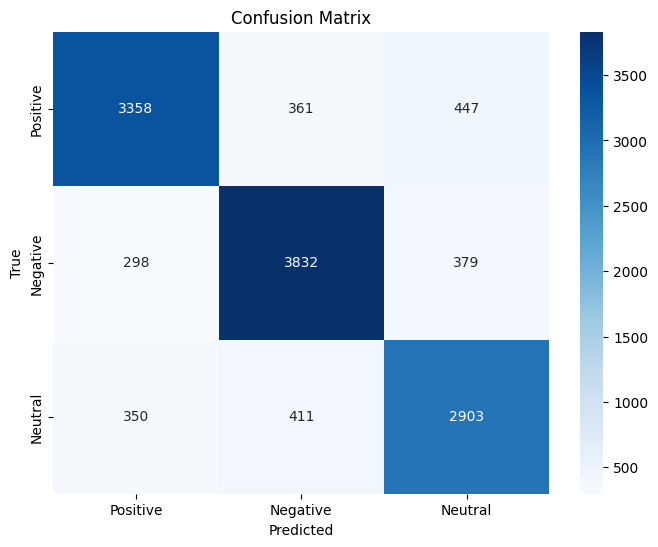

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

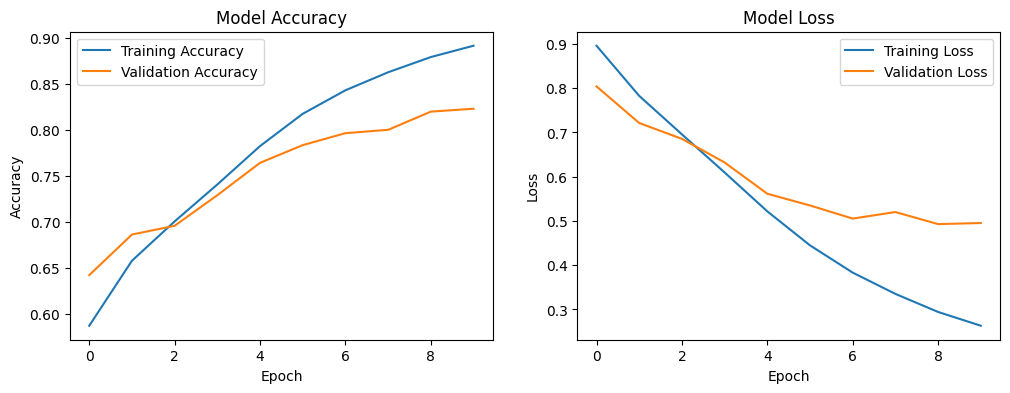

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# 6. Fine-tuning (Example: Continue with lower learning rate)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 403s 645ms/step - accuracy: 0.9055 - loss: 0.2260 - val_accuracy: 0.8288 - val_loss: 0.4903 - learning_rate: 1.0000e-04
Epoch 2/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 481s 708ms/step - accuracy: 0.9146 - loss: 0.1993 - val_accuracy: 0.8312 - val_loss: 0.5102 - learning_rate: 1.0000e-04
Epoch 3/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 408s 662ms/step - accuracy: 0.9160 - loss: 0.1949 - val_accuracy: 0.8340 - val_loss: 0.5080 - learning_rate: 1.0000e-04
Epoch 4/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 447s 670ms/step - accuracy: 0.9192 - loss: 0.1852 - val_accuracy: 0.8344 - val_loss: 0.5158 - learning_rate: 2.0000e-05
